### **Load Dataset**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hayammostafa","key":"1bb4ad4704e1bdec4c21c16d08d4daae"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d monal007/traindata
!unzip traindata.zip -d traindata

Dataset URL: https://www.kaggle.com/datasets/monal007/traindata
License(s): unknown
  0% 0.00/37.0M [00:00<?, ?B/s]
100% 37.0M/37.0M [00:00<00:00, 857MB/s]
Archive:  traindata.zip
  inflating: traindata/train.csv     


### **Imports**

In [4]:
import pandas as pd, numpy as np, re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

### **Information Dataset**

In [7]:
news_dataset = pd.read_csv("/content/traindata/train.csv")

In [8]:
news_dataset.shape

(20800, 5)

In [9]:
news_dataset.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [10]:
counts = news_dataset['label'].value_counts()
for label, count in counts.items():
    if label == 0:
        print(f"Real News Count: {count}")
    else:
        print(f"Fake News Count: {count}")


Fake News Count: 10413
Real News Count: 10387


### **Preprocessing**

In [11]:
missing_values_before = news_dataset.isnull().sum()
print(missing_values_before)

id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [12]:
news_dataset = news_dataset.fillna('')

In [13]:
missing_values_after = news_dataset.isnull().sum()
print(missing_values_after)

id        0
title     0
author    0
text      0
label     0
dtype: int64


In [14]:
news_dataset['content'] = news_dataset['author']+' '+news_dataset['title']
news_dataset['content'].head()

0    Darrell Lucus House Dem Aide: We Didn’t Even S...
1    Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2    Consortiumnews.com Why the Truth Might Get You...
3    Jessica Purkiss 15 Civilians Killed In Single ...
4    Howard Portnoy Iranian woman jailed for fictio...
Name: content, dtype: object

In [15]:
X = news_dataset.drop(columns='label', axis=1)
Y = news_dataset['label']

In [16]:
print(X)
print("-----------------------------------------------------------")
print(Y)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

#### **Stemming**

In [17]:
def stemming(content):

    stemmed_content = re.sub('[^a-zA-Z]',' ',content)

    stemmed_content = stemmed_content.lower()

    stemmed_content = stemmed_content.split()

    port_stem = PorterStemmer()

    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]

    stemmed_content = ' '.join(stemmed_content)

    return stemmed_content

In [18]:
tqdm.pandas()

news_dataset['content'] = news_dataset['content'].progress_apply(stemming)

print("\n\nStemming has been successfully applied to texts.")


100%|██████████| 20800/20800 [00:49<00:00, 423.34it/s]



Stemming has been successfully applied to texts.


In [19]:
print(news_dataset['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [20]:
X = news_dataset['content'].values
Y = news_dataset['label'].values

In [21]:
print(X)
print("------------------------------------------")
print(Y)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']
------------------------------------------
[1 0 1 ... 0 1 1]


In [22]:
Y.shape

(20800,)

### **Feature Extract**

In [23]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))

vectorizer.fit(news_dataset['content'])

X = vectorizer.transform(news_dataset['content'])

In [24]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 210687 stored elements and shape (20800, 17128)>
  Coords	Values
  (0, 267)	0.2701012497770876
  (0, 2483)	0.36765196867972083
  (0, 2959)	0.24684501285337127
  (0, 3600)	0.3598939188262558
  (0, 3792)	0.27053324808454915
  (0, 4973)	0.23331696690935097
  (0, 7005)	0.2187416908935914
  (0, 7692)	0.24785219520671598
  (0, 8630)	0.2921251408704368
  (0, 8909)	0.36359638063260746
  (0, 13473)	0.2565896679337956
  (0, 15686)	0.2848506356272864
  (1, 1497)	0.2939891562094648
  (1, 1894)	0.15521974226349364
  (1, 2223)	0.3827320386859759
  (1, 2813)	0.19094574062359204
  (1, 3568)	0.26373768806048464
  (1, 5503)	0.7143299355715573
  (1, 6816)	0.1904660198296849
  (1, 16799)	0.30071745655510157
  (2, 2943)	0.3179886800654691
  (2, 3103)	0.46097489583229645
  (2, 5389)	0.3866530551182615
  (2, 5968)	0.3474613386728292
  (2, 9620)	0.49351492943649944
  :	:
  (20797, 3643)	0.2115550061362374
  (20797, 7042)	0.21799048897828685
  (2079

### **Split Dataset To Train and Test**

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

In [26]:
print(f"Number of training data items: {X_train.shape[0]}")
print(f"Number of testing data items: {X_test.shape[0]}")

Number of training data items: 16640
Number of testing data items: 4160


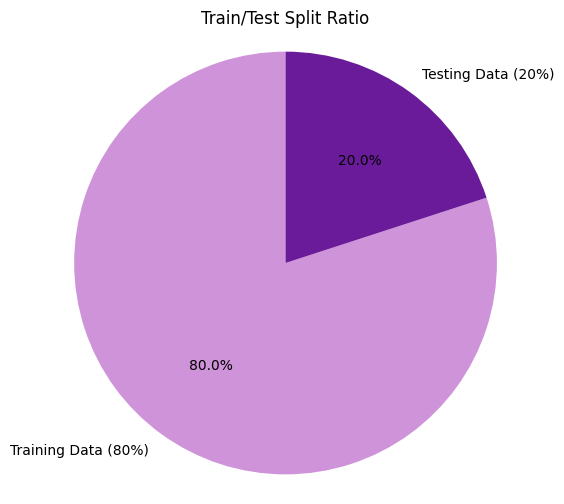

In [27]:
import matplotlib.pyplot as plt

# Sizes of the splits
train_size = X_train.shape[0]
test_size = X_test.shape[0]

# Labels and values
labels = ['Training Data (80%)', 'Testing Data (20%)']
sizes = [train_size, test_size]

# Purple colors (light and dark)
colors = ['#CE93D8', '#6A1B9A']

# Create pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Train/Test Split Ratio')
plt.axis('equal')
plt.show()


### **Model without PCA**

In [28]:
# Logistic Regression
log_reg = LogisticRegression(C=0.1,max_iter=1000)
log_reg.fit(X_train, Y_train)

LogisticRegression(C=0.1, max_iter=1000)

In [29]:
X_train_prediction = log_reg.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print(f'Accuracy score of Logistic Regression on training data: {training_data_accuracy * 100:.2f}%')

Accuracy score of Logistic Regression on training data: 94.06%


In [30]:
X_test_prediction = log_reg.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)
print(f'Accuracy score of Logistic Regression on testing data: {test_data_accuracy * 100:.2f}%')

Accuracy score of Logistic Regression on testing data: 93.85%


### **Model with PCA**

In [31]:
print(X_train.shape)

(16640, 17128)


In [32]:
pca = PCA(n_components=500)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [33]:
print(X_train_pca.shape)

(16640, 500)


In [34]:
log_reg_pca = LogisticRegression()
log_reg_pca.fit(X_train_pca, Y_train)

LogisticRegression()

In [35]:
X_train_prediction_pca = log_reg_pca.predict(X_train_pca)
training_data_accuracy_pca = accuracy_score(Y_train, X_train_prediction_pca)
print(f'Accuracy score of Logistic Regression on training data (with PCA): {training_data_accuracy_pca * 100:.2f}%')

Accuracy score of Logistic Regression on training data (with PCA): 96.98%


In [36]:
X_test_prediction_pca = log_reg_pca.predict(X_test_pca)
test_data_accuracy_pca = accuracy_score(Y_test, X_test_prediction_pca)
print(f'Accuracy score of Logistic Regression on testing data (with PCA): {test_data_accuracy_pca * 100:.2f}%')

Accuracy score of Logistic Regression on testing data (with PCA): 96.80%


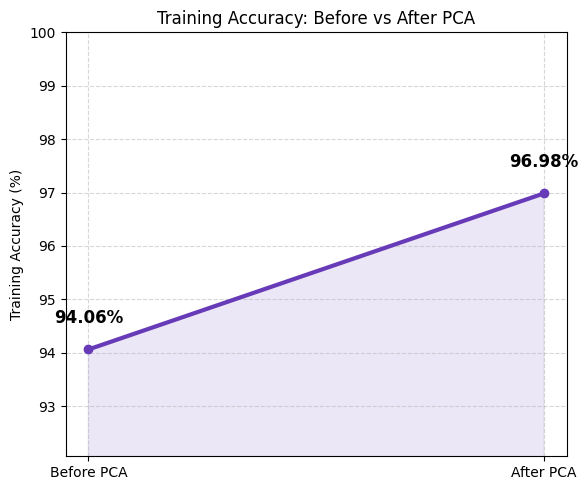

In [37]:
labels = ['Before PCA', 'After PCA']
accuracies = [training_data_accuracy * 100, training_data_accuracy_pca * 100]

plt.figure(figsize=(6, 5))
plt.plot(labels, accuracies, marker='o', color='#673AB7', linewidth=3)
plt.fill_between(labels, accuracies, color='#D1C4E9', alpha=0.4)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.5, f'{acc:.2f}%', ha='center', fontweight='bold', fontsize=12)

plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy: Before vs After PCA')
plt.ylim(min(accuracies) - 2, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## **GUI**

In [50]:
!pip install gradio

In [ ]:
import gradio as gr

def predict_news(text):
    processed_text = stemming(text)

    X_new = vectorizer.transform([processed_text])

    X_new_pca= pca.transform(X_new.toarray())

    prediction = log_reg_pca.predict(X_new_pca)

    return "The news is Real" if prediction[0] == 0 else "The news is Fake"

css = """
.description {
    font-size: 30 px !important;
    font-weight: bold !important;
    text-align: center !important;
}
"""
interface = gr.Interface(
    fn=predict_news,
    inputs="text",
    outputs="text",
    title="Fake News Detection",
    description="Enter news text to check if it's real or fake 📰",
    css=css,
    allow_flagging="never",

)

interface.launch(debug=True)

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:419: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://96ce95aa068aa02997.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
